# Import Dependencies

In [1]:
import os
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, LearningCurveDisplay
from sklearn.metrics import classification_report, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_sample_weight

# Understanding the Dataset

In [2]:
path = os.path.join('datasets', 'creditcard', 'creditcard.csv')
df = pd.read_csv(path)

In [3]:
# First five rows of the dataset
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### This dataset includes 
- **30 features**
- one label column which is the **class of transactions**, **0** for **normal transactions** and **1** for **fraudulent transactions**
- No **null value**


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Class imbalance

As expected, the credit card dataset is imbalanced, which means there are too many non-fraudulent (normal) transactions compared to fraudulent ones. 
In our case, there are: 
- **284315** normal transactions against only 
- **492** fraudulent transactions. 

As we'll see, this skewed data can affect the accuracy of the models. 

In [5]:
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

### Feature scaling

Features have different scale! 

With the data description and histograms, we can see that 
- **V's features** are spread around **0** while
- **Time** and **Amount** ranges respectively from  **0** to **172792** and  **0** to **25691**.

This can affect the efficiency of the gradient descent algorithm. Indeed, it may take too long to converge.

To avoid this problem, we need to perform a data transformation called **feature scaling** on our features Time and Amount.
I'll apply the MinMax Normalization: 
$$x_i = \dfrac{x_i - min}{max - min} $$

In [6]:
# Quick statistical insights
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


array([[<Axes: title={'center': 'Time'}>, <Axes: title={'center': 'V1'}>,
        <Axes: title={'center': 'V2'}>, <Axes: title={'center': 'V3'}>,
        <Axes: title={'center': 'V4'}>, <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>, <Axes: title={'center': 'V9'}>,
        <Axes: title={'center': 'V10'}>, <Axes: title={'center': 'V11'}>],
       [<Axes: title={'center': 'V12'}>, <Axes: title={'center': 'V13'}>,
        <Axes: title={'center': 'V14'}>, <Axes: title={'center': 'V15'}>,
        <Axes: title={'center': 'V16'}>, <Axes: title={'center': 'V17'}>],
       [<Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>, <Axes: title={'center': 'V21'}>,
        <Axes: title={'center': 'V22'}>, <Axes: title={'center': 'V23'}>],
       [<Axes: title={'center': 'V24'}>, <Axes: title={'center': 'V25'}>,
        <Axes: title={'center': 'V26'}>, <

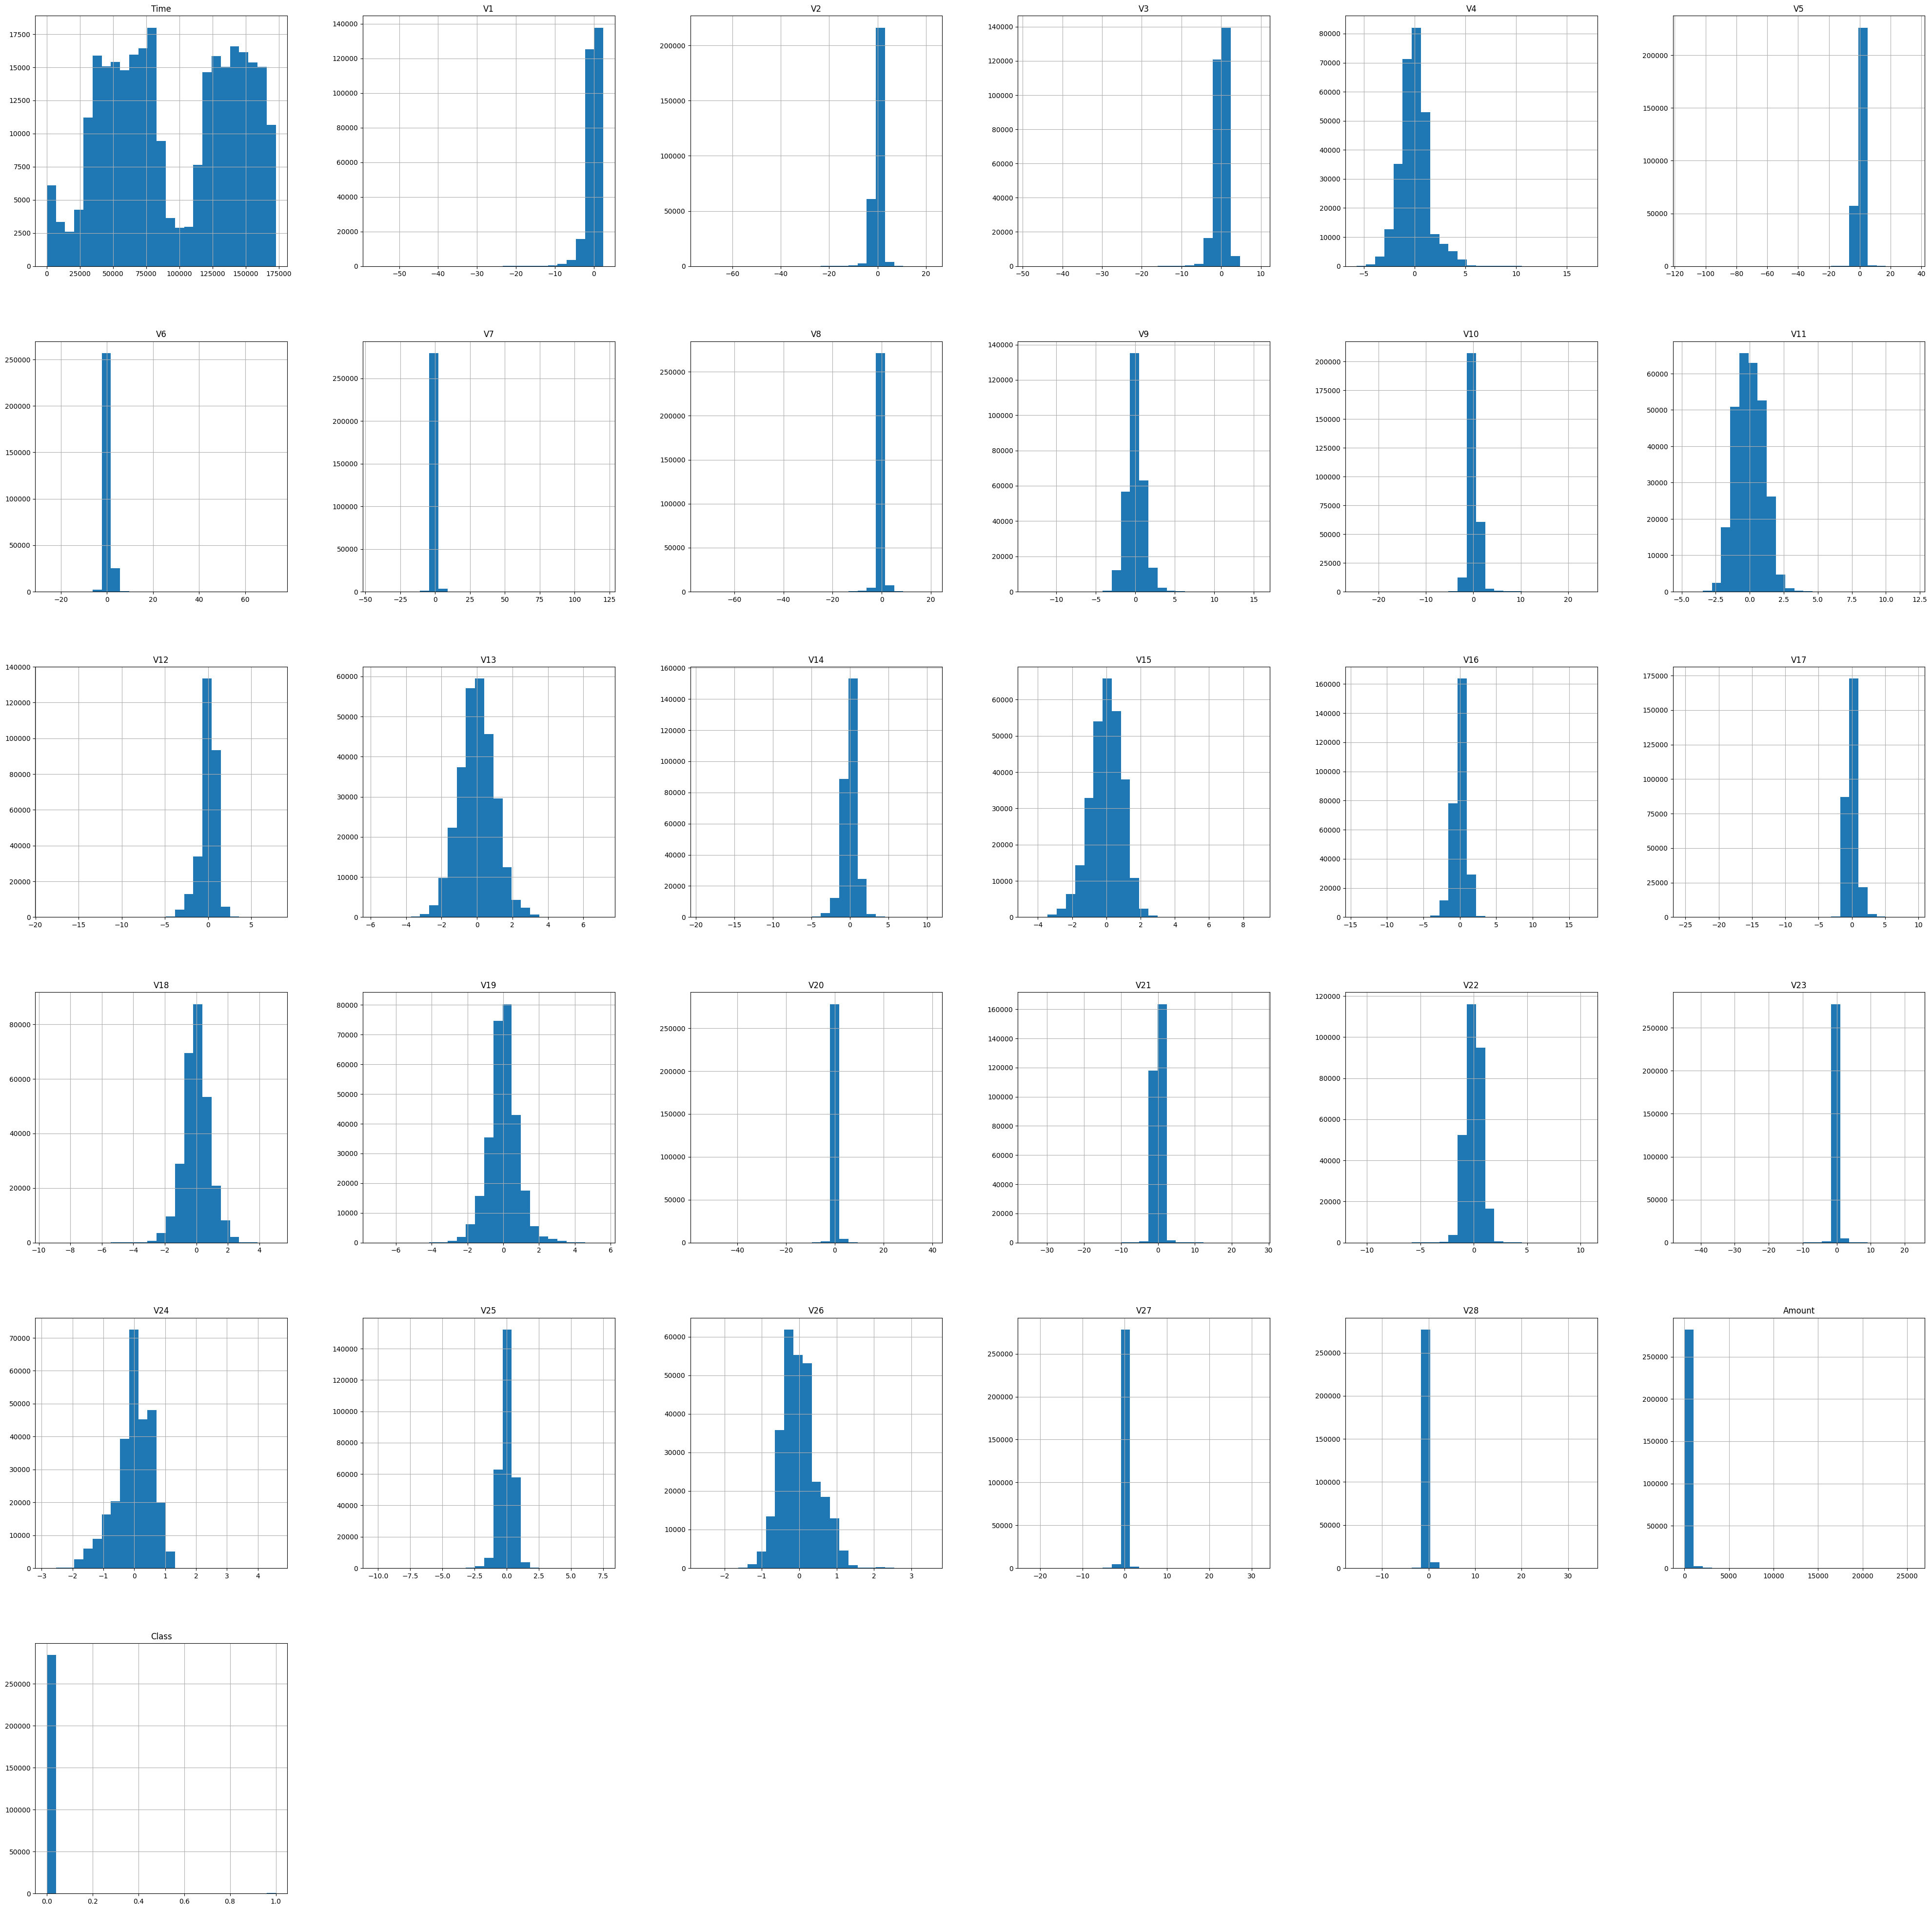

In [7]:
df.hist(bins=25, figsize=(50,50))

<Axes: >

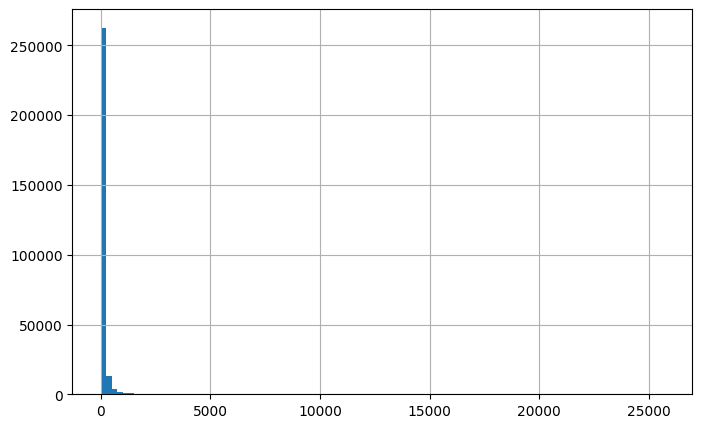

In [8]:
#Zoom in on the amount feature
df["Amount"].hist(bins=100, figsize=(8, 5))

<Axes: >

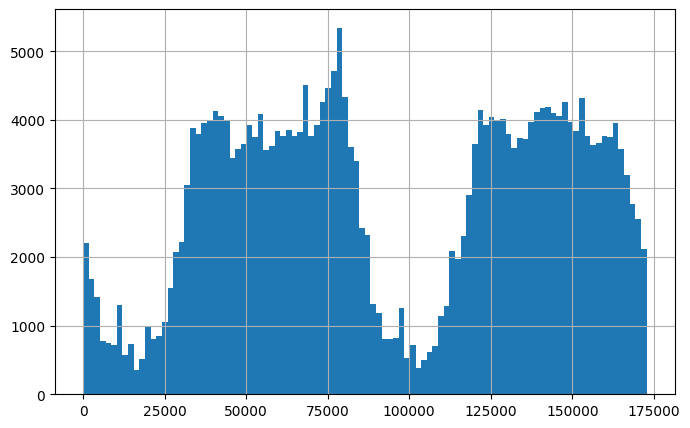

In [9]:
# Zoom in on the Time feature
df["Time"].hist(bins=100, figsize=(8,5))

## Separate the features from the ground truth

In [10]:
Y = df["Class"]
X = df.drop("Class", axis=1)

In [11]:
X.shape

(284807, 30)

## Split the dataset into train, validation and test set

In [12]:
x_train,x_,y_train,y_ = train_test_split(X, Y, test_size= 0.4, random_state=42)
x_test,x_val,y_test,y_val = train_test_split(x_, y_, test_size= 0.5, random_state=42)

# Delete temporary variables x_ and y_
del x_,y_ 

# Feature Engineering

In [13]:
# MinMax normalization 
cols_to_scale = ["Time", "Amount"]

scaler = MinMaxScaler()
x_train[cols_to_scale] = scaler.fit_transform(x_train[cols_to_scale])


x_val[cols_to_scale] = scaler.transform(x_val[cols_to_scale])
x_test[cols_to_scale] = scaler.transform(x_test[cols_to_scale])

In [14]:
x_train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,170884.000000,170884.000000,170884.000000,170884.000000,170884.000000,170884.000000,170884.000000,170884.000000,170884.000000,170884.000000,...,170884.000000,170884.000000,170884.000000,170884.000000,170884.000000,170884.000000,170884.000000,170884.000000,170884.000000,170884.000000
mean,0.548159,-0.004503,-0.004144,0.001570,-0.001828,0.002360,-0.002739,0.000922,-0.001024,-0.000175,...,-0.000328,-0.000050,-0.002460,-0.000053,0.000043,-0.001908,0.000489,-0.001040,-0.000121,0.003454
std,0.274808,1.969238,1.680157,1.514566,1.417296,1.393556,1.338739,1.245682,1.191403,1.096579,...,0.785533,0.734941,0.726002,0.637011,0.604972,0.523159,0.482341,0.408465,0.332173,0.010036
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.320155,...,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-9.895244,-15.430084,0.000000
25%,0.313436,-0.923552,-0.599973,-0.886777,-0.850616,-0.689489,-0.767972,-0.550519,-0.207647,-0.641896,...,-0.212177,-0.229041,-0.544293,-0.161506,-0.354127,-0.318535,-0.326848,-0.071191,-0.053262,0.000218
50%,0.489455,0.009999,0.066454,0.182367,-0.022519,-0.055931,-0.273652,0.042958,0.022019,-0.049751,...,-0.062481,-0.029792,0.004217,-0.010594,0.041347,0.013232,-0.050532,0.001181,0.011325,0.000856
75%,0.805929,1.314722,0.802815,1.028302,0.738205,0.609197,0.392697,0.570395,0.327051,0.597959,...,0.133844,0.186094,0.525867,0.148014,0.439140,0.349974,0.242267,0.091125,0.078599,0.003017
max,1.000000,2.454930,22.057729,4.101716,16.875344,34.801666,73.301626,120.589494,20.007208,10.348407,...,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,1.000000


# Model building

In this section, we'll build our candidate models. 

As we saw in the last sections, our dataset is heavily imbalanced and we'll see its impact on model accuracy.

To mitigate this problem, we'll build three versions of each candidate model: 

- **imbalanced**: models with this label are trained on the entire training set,
  
- **balanced**: these models are trained on a re-balanced dataset by downsampling the majority class,
  
- **weighted**: trained on the entire training set with a weighted loss function. Weights are inversely proportional to the size of each class so that minority classes get higher weight.


We'll use these metrics to weigh the performance of our models:

- **Accuracy**: is a global metric which equally treats classes

$$\text{Accuracy} = \frac{\text{TP + TN}}{\text{TP + TN + FP + FN}}$$

- **Recall**:
A proportion of the positive class that the model predicts correctly.
A low recall means high number of False Negatives - fraudulent transactions predicted as normal ones, while high recall means the model performs very well on the positive class by having a few number of False Negatives.
  

$$\text{Recall} = \frac{\text{TP}}{\text{TP + FN}}$$
  
- **Precision**: provides insight into the number of false positives - normal transactions predicted as fraudulent ones. High precision means low number of false positives, and vice-versa.

$$\text{Precision} = \frac{\text{TP}}{\text{TP + FP}}$$
  
- **F1-score**: provides insight into both Recall and Precision. It's defined such that high F1 score means high Recall and high Precision value.

$$\text{F1-score} = \frac{1}{\frac{1}{2} \times (\frac{1}{\text{Recall}} + \frac{1}{\text{Precision}})}$$



## Helper Functions

In [15]:
def displayLearningCurves(model, X, Y, train_sizes, perf_metric, name, version):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_title(f"Learning Curves of the {version}_{model.__class__.__name__} classifier")
    common_params = {
        "X": X,
        "y": Y,
        "train_sizes": train_sizes,
        "score_type": 'both',
        "cv": 5,  # As we're working with a classification problem cv used StratifiedKFold strategy
        "scoring": perf_metric,
        "n_jobs": 4,
        "line_kw": {"linestyle": "-", "marker": "o"},
        "score_name": name,
        "ax": ax
    }
    LearningCurveDisplay.from_estimator(estimator=model, **common_params)

In [16]:
# x = np.arange(0.,1.1,0.1)
# y_1 = -np.log(x)
# y_2 = -np.log(1-x)

In [17]:
# fig,ax = plt.subplots(1,2, figsize=(12,5), sharex=True)
# ax[0].plot(x,y_1, c='blue')
# ax[0].set_xlabel('Probability p')
# ax[0].set_ylabel('Entropy when y_i = 1')
# ax[1].plot(x,y_2, c='blue')
# ax[1].set_ylabel('Entropy when y_i = 0')
# ax[1].set_xlabel('Probability p')
# plt.show()

## Working with Imbalanced Versions

#### Logistic Regression

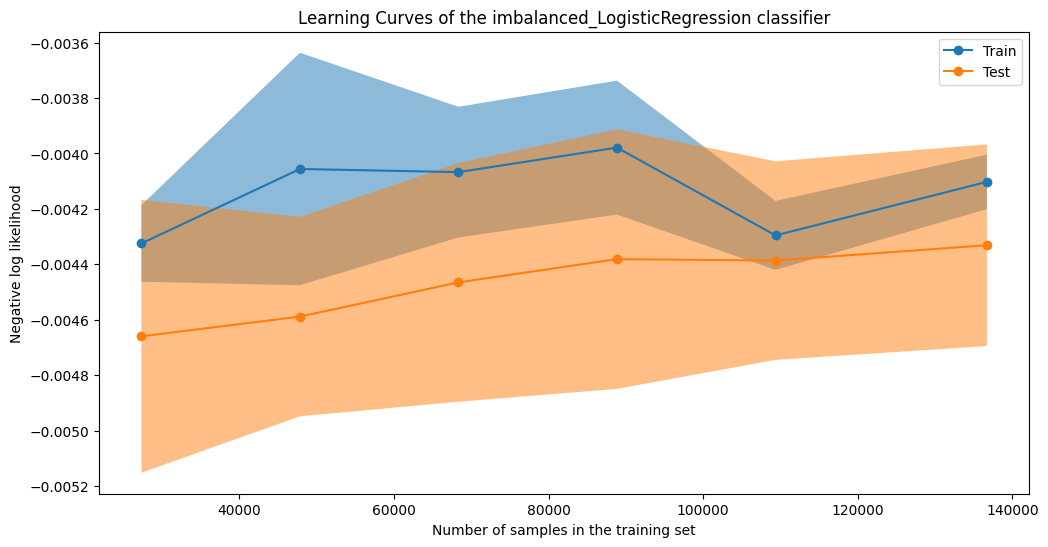

In [18]:
logistic_model_1 = LogisticRegression(max_iter=1000)
displayLearningCurves(
    logistic_model_1, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative log likelihood',
    'imbalanced'
)

In [19]:
logistic_model_1.fit(x_train, y_train)
print(classification_report(y_val, logistic_model_1.predict(x_val), target_names = ['Non-Fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-Fraudulent       1.00      1.00      1.00     56869
    Fraudulent       0.87      0.66      0.75        93

      accuracy                           1.00     56962
     macro avg       0.94      0.83      0.87     56962
  weighted avg       1.00      1.00      1.00     56962



#### Decision trees

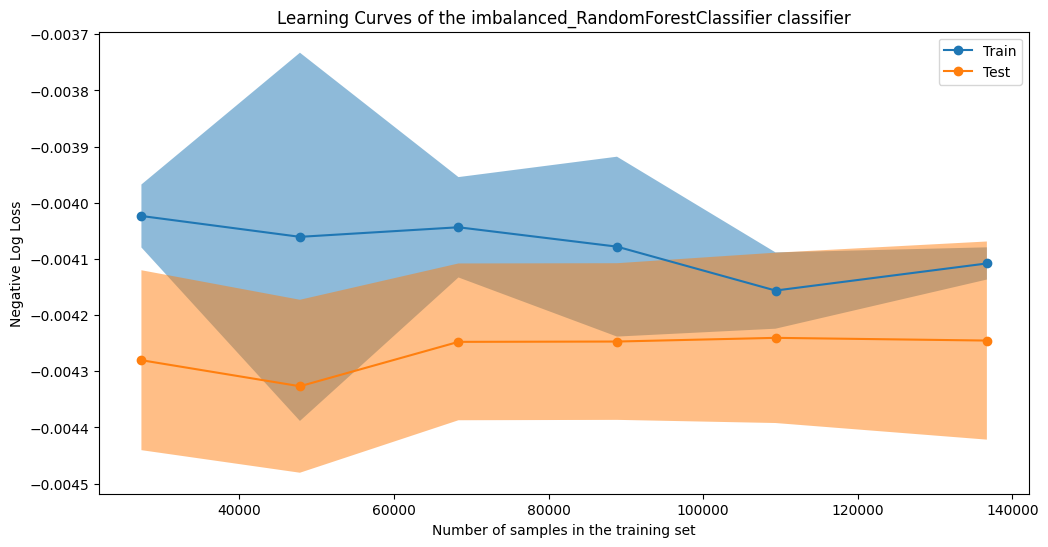

In [20]:
rf_1 = RandomForestClassifier(max_depth=2, n_jobs=-1, random_state=42)
displayLearningCurves(
    rf_1, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative Log Loss',
    'imbalanced'
)

In [21]:
rf_1.fit(x_train,y_train)
print(classification_report(y_val, rf_1.predict(x_val), target_names = ['Non-fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-fraudulent       1.00      1.00      1.00     56869
    Fraudulent       0.86      0.60      0.71        93

      accuracy                           1.00     56962
     macro avg       0.93      0.80      0.85     56962
  weighted avg       1.00      1.00      1.00     56962



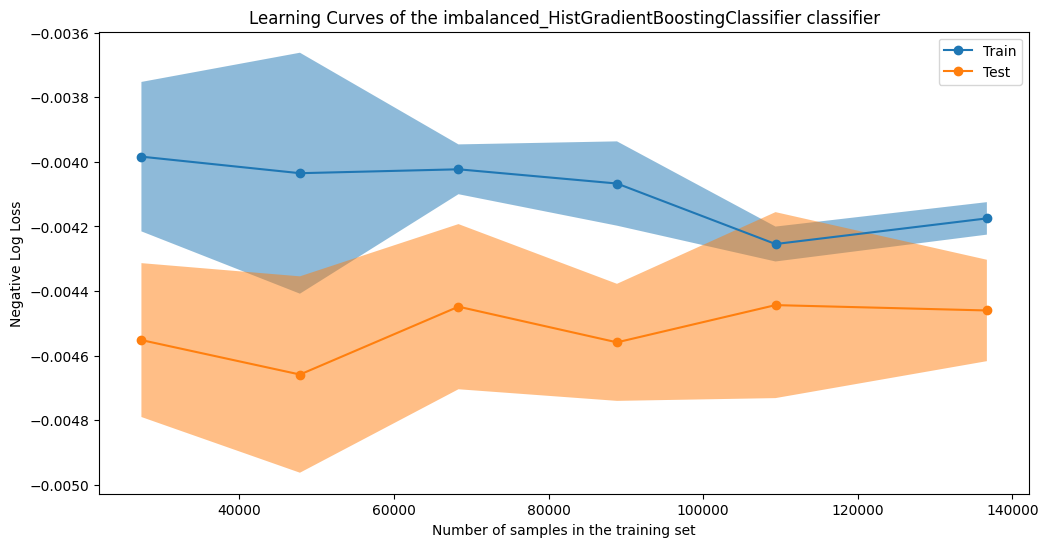

In [22]:
xgb_1= HistGradientBoostingClassifier(max_depth=2, learning_rate= 0.01,  early_stopping=True, random_state=42)
# early_stopping prevents the model from overfitting the training data
# l2_regularization=0.01

displayLearningCurves(
    xgb_1, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative Log Loss',
    'imbalanced'
)


In [23]:
xgb_1.fit(x_train,y_train)
print(classification_report(y_val, xgb_1.predict(x_val), target_names = ['Non-fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-fraudulent       1.00      1.00      1.00     56869
    Fraudulent       0.86      0.75      0.80        93

      accuracy                           1.00     56962
     macro avg       0.93      0.88      0.90     56962
  weighted avg       1.00      1.00      1.00     56962



#### Support Vector Machine

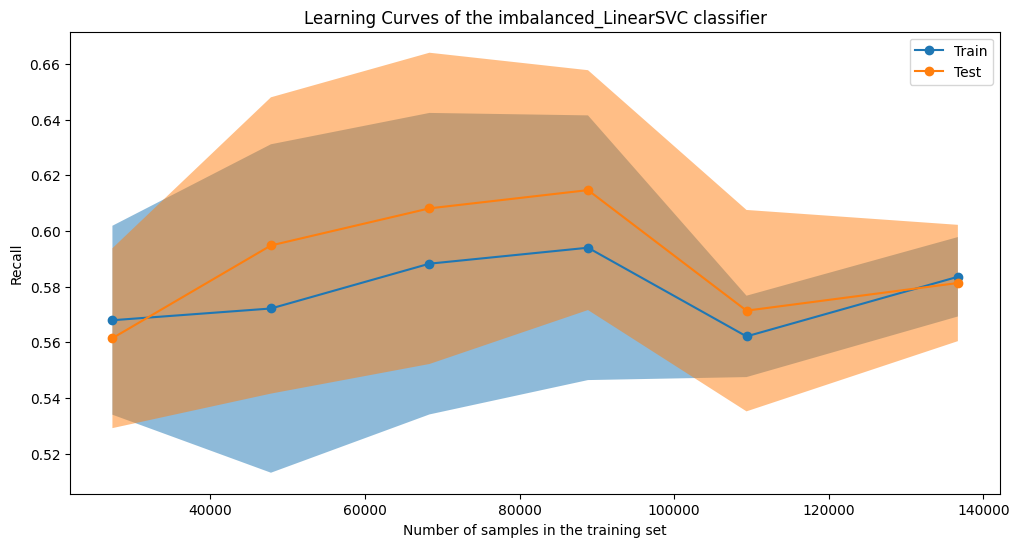

In [24]:
svc_1 = LinearSVC()

displayLearningCurves(
    svc_1, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'recall',
    'Recall',
    'imbalanced'
)


In [25]:
svc_1.fit(x_train, y_train)
print(classification_report(y_val, svc_1.predict(x_val), target_names = ['Non-fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-fraudulent       1.00      1.00      1.00     56869
    Fraudulent       0.88      0.63      0.74        93

      accuracy                           1.00     56962
     macro avg       0.94      0.82      0.87     56962
  weighted avg       1.00      1.00      1.00     56962



### Wrap up:

If you've been paying attention to the accuracy of all models, you may have noticed that the model accuracy is always equal to 1 surprisingly. This is because accuracy is a global metric that treats all classes equally. As a consequence, the class with high frequence dominates the metric. In our case the fraudulent class represents less than 1% of the dataset which is highly imbalanced and makes accuracy a misleading metric of the model performance.

The second thing to notice is that our models do not overfit, which is good news. However, something interesting happens when the size of the training set reaches around 110,000: the training loss starts slowly decreasing while the validation loss remains relatively constant. This indicates, to some extent, that increasing the size of the training set can benefit the model, although we should pay attention to it because it could eventually lead to overfitting.

The golden model with regard to precision and recall of this section: **xgb_1** with **Precision = 0.86** and **Recall = 0.75**

## Working with Balanced Versions

#### Re-balancing the dataset

In [26]:
non_fraud_df = df[df["Class"] == 0].reset_index(drop=True) # indexes get dropped and restart from 0
fraud_df = df[df["Class"] == 1].reset_index(drop=True)
# non_fraud_df.info()
# print("\n\n")
# fraud_df.info()

#Downsample the non_fraud datatframe
non_fraud_df = resample(
    non_fraud_df,
    replace= True, 
    n_samples= len(fraud_df), 
    random_state= 42
).reset_index(drop=True)


balanced_pf = pd.concat([non_fraud_df, fraud_df], axis=0, ignore_index=True)\
                .sample(frac=1, random_state=42)\
                .reset_index(drop=True)           

balanced_pf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    984 non-null    float64
 1   V1      984 non-null    float64
 2   V2      984 non-null    float64
 3   V3      984 non-null    float64
 4   V4      984 non-null    float64
 5   V5      984 non-null    float64
 6   V6      984 non-null    float64
 7   V7      984 non-null    float64
 8   V8      984 non-null    float64
 9   V9      984 non-null    float64
 10  V10     984 non-null    float64
 11  V11     984 non-null    float64
 12  V12     984 non-null    float64
 13  V13     984 non-null    float64
 14  V14     984 non-null    float64
 15  V15     984 non-null    float64
 16  V16     984 non-null    float64
 17  V17     984 non-null    float64
 18  V18     984 non-null    float64
 19  V19     984 non-null    float64
 20  V20     984 non-null    float64
 21  V21     984 non-null    float64
 22  V2

#### train, val, test sets

In [27]:
Yb = balanced_pf["Class"]
Xb = balanced_pf.drop("Class", axis=1)

# Splitting into training, eval and test sets
xb_train,xb_,yb_train,yb_ = train_test_split(Xb, Yb, test_size= 0.4, random_state=42)
xb_test,xb_val,yb_test,yb_val = train_test_split(xb_, yb_, test_size= 0.5, random_state=42)

# Delete temporary variables x_ and y_
del xb_,yb_ 

# MinMax normalization 
cols_to_scale = ["Time", "Amount"]

scaler = MinMaxScaler()
xb_train[cols_to_scale] = scaler.fit_transform(xb_train[cols_to_scale])


xb_val[cols_to_scale] = scaler.transform(xb_val[cols_to_scale])
xb_test[cols_to_scale] = scaler.transform(xb_test[cols_to_scale])

#### Logistic Regression 

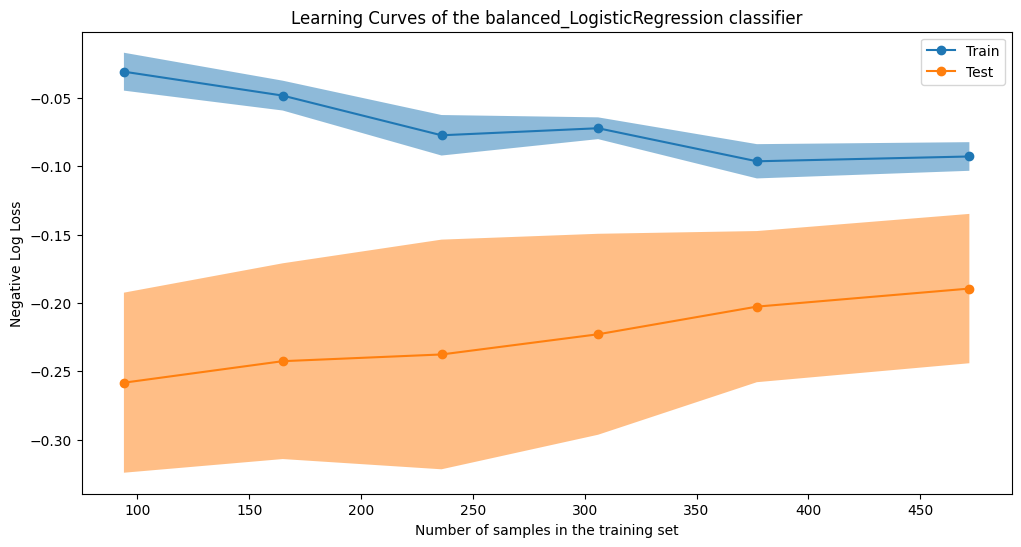

In [28]:
logistic_model_2 = LogisticRegression(max_iter=1000)
displayLearningCurves(
    logistic_model_2 , 
    xb_train, 
    yb_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative Log Loss',
    'balanced'
)


In [29]:
logistic_model_2.fit(xb_train, yb_train)
print(classification_report(yb_val, logistic_model_2.predict(xb_val), target_names=['Non-fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-fraudulent       0.92      0.97      0.95       113
    Fraudulent       0.96      0.89      0.93        84

      accuracy                           0.94       197
     macro avg       0.94      0.93      0.94       197
  weighted avg       0.94      0.94      0.94       197



#### Decision trees 

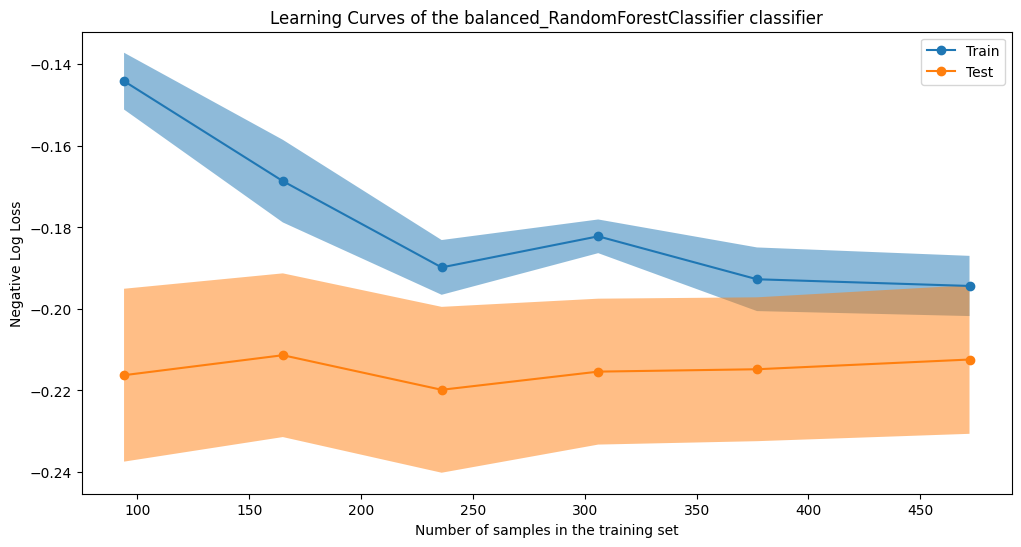

In [30]:
rf_2 = RandomForestClassifier(max_depth=2, n_jobs=-1, random_state=42)
displayLearningCurves(
    rf_2, 
    xb_train, 
    yb_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative Log Loss',
    'balanced'
)


In [31]:
rf_2.fit(xb_train, yb_train)
print(classification_report(yb_val, rf_2.predict(xb_val), target_names = ['Non-fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-fraudulent       0.88      1.00      0.94       113
    Fraudulent       1.00      0.82      0.90        84

      accuracy                           0.92       197
     macro avg       0.94      0.91      0.92       197
  weighted avg       0.93      0.92      0.92       197



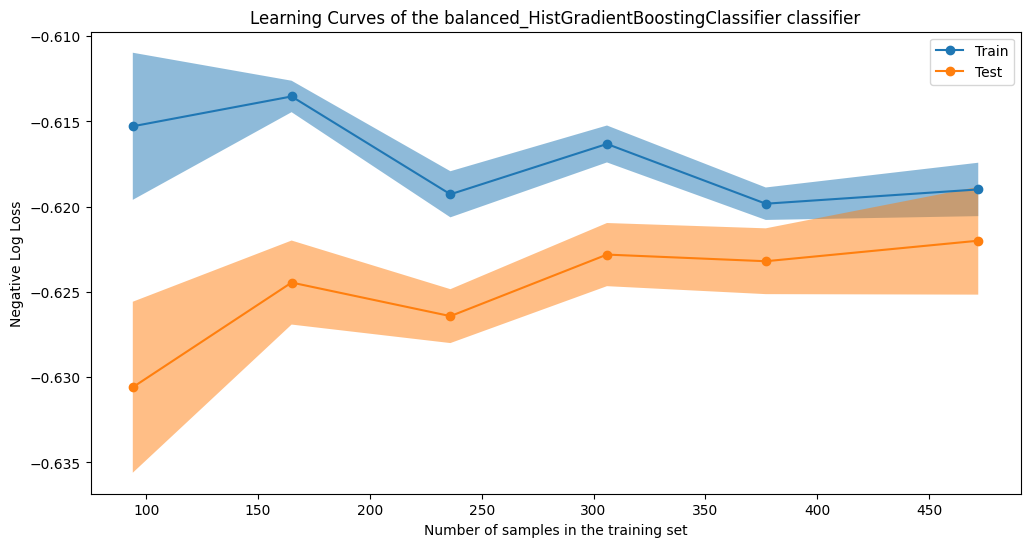

In [32]:
xgb_2 = HistGradientBoostingClassifier(max_depth=2, learning_rate= 0.001,  early_stopping=True, random_state=42)

displayLearningCurves(
    xgb_2, 
    xb_train, 
    yb_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative Log Loss',
    'balanced',
)


In [33]:
xgb_2.fit(xb_train,yb_train)
print(classification_report(yb_val, xgb_2.predict(xb_val), target_names = ['Non-fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-fraudulent       0.94      0.93      0.93       113
    Fraudulent       0.91      0.92      0.91        84

      accuracy                           0.92       197
     macro avg       0.92      0.92      0.92       197
  weighted avg       0.92      0.92      0.92       197



#### Support Vector Machine 

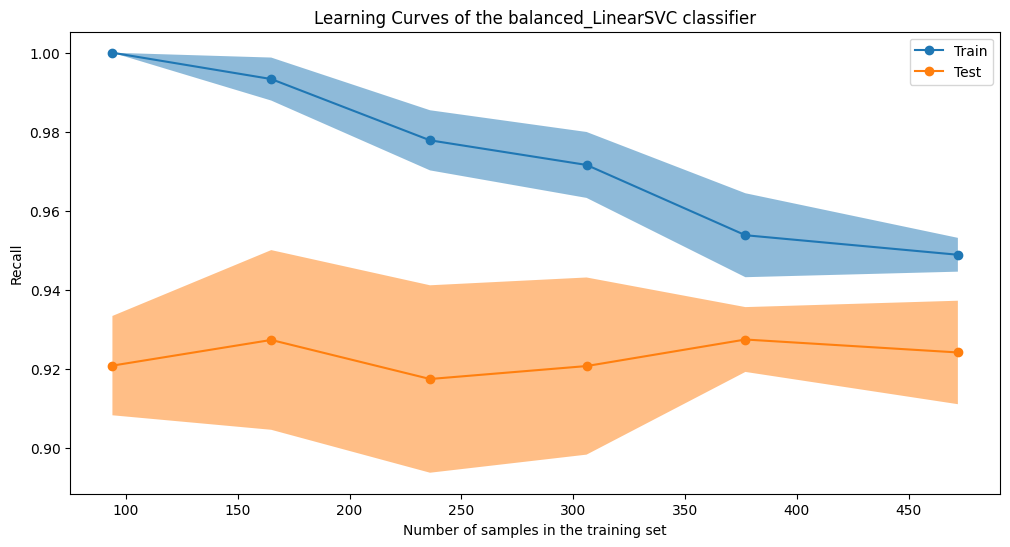

In [34]:
svc_2 = LinearSVC()
displayLearningCurves(
    svc_2, 
    xb_train, 
    yb_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'recall',
    'Recall',
    'balanced'
)


In [35]:
svc_2.fit(xb_train,yb_train)
print(classification_report(yb_val, svc_2.predict(xb_val), target_names = ['Non-fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-fraudulent       0.92      0.96      0.94       113
    Fraudulent       0.94      0.89      0.91        84

      accuracy                           0.93       197
     macro avg       0.93      0.92      0.93       197
  weighted avg       0.93      0.93      0.93       197



### Wrap up:

The first thing to notice is that the accuracy is no longer constant and set to 1 as the dataset si now fairly distributed.

Again, our models did not overfit the training data. Having a balanced dataset helped the models encounter fraudulent and normal transactions equally, making them more robust. In contrast to the previous section, the training loss no longer decreases toward the end of the training process. Instead, it seems to reach a plateau in most cases.

The golden model of this section: **xgb_2** with **Precision = 0.91** and **Recall = 0.92**

## Working with Weighted Versions

#### Logistic Regression

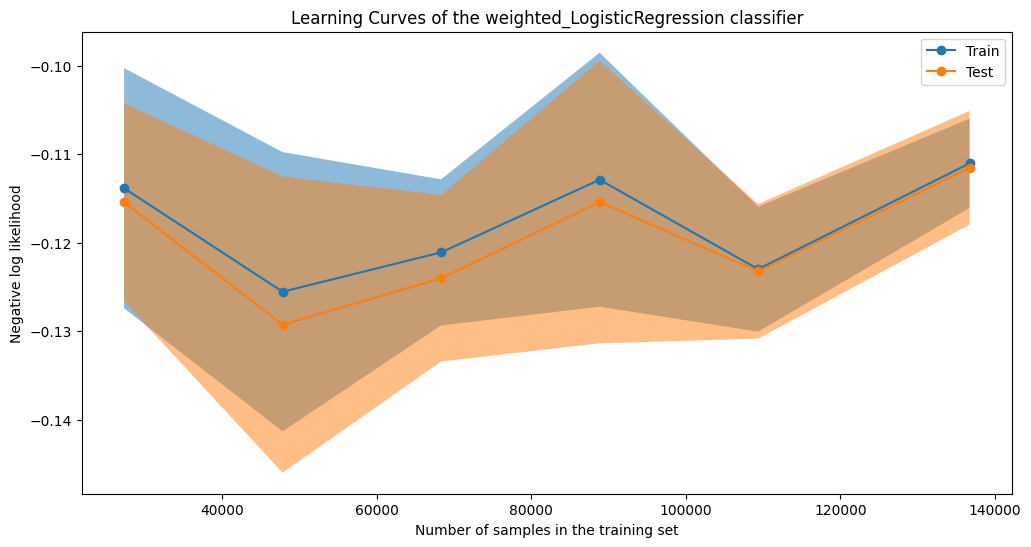

In [36]:
logistic_model_3 = LogisticRegression(max_iter=200, class_weight='balanced', random_state=42)
displayLearningCurves(
    logistic_model_3, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative log likelihood',
    'weighted'
)

In [37]:
# print(hasattr(logistic_model_2, 'coef_'))
logistic_model_3.fit(x_train, y_train)
print(classification_report(y_val, logistic_model_3.predict(x_val), target_names=['Non-Fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-Fraudulent       1.00      0.98      0.99     56869
    Fraudulent       0.06      0.91      0.11        93

      accuracy                           0.98     56962
     macro avg       0.53      0.95      0.55     56962
  weighted avg       1.00      0.98      0.99     56962



#### Decision trees

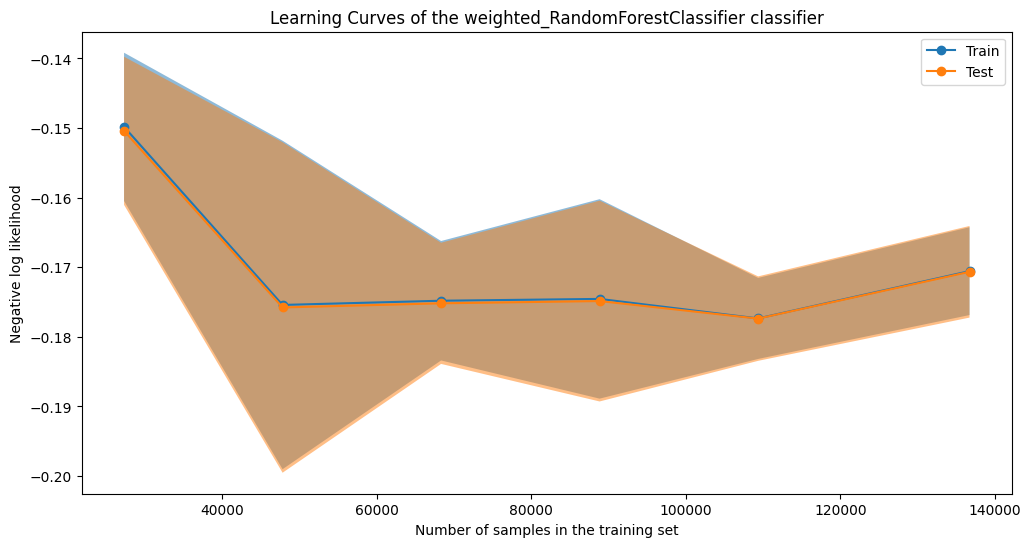

In [38]:
rf_3 = RandomForestClassifier(max_depth=2, n_jobs=-1, random_state=42, class_weight='balanced')
displayLearningCurves(
    rf_3, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative log likelihood',
    'weighted'
)

In [39]:
rf_3.fit(x_train,y_train)
print(classification_report(y_val, rf_3.predict(x_val), target_names = ['Non-Fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-Fraudulent       1.00      1.00      1.00     56869
    Fraudulent       0.34      0.88      0.49        93

      accuracy                           1.00     56962
     macro avg       0.67      0.94      0.75     56962
  weighted avg       1.00      1.00      1.00     56962



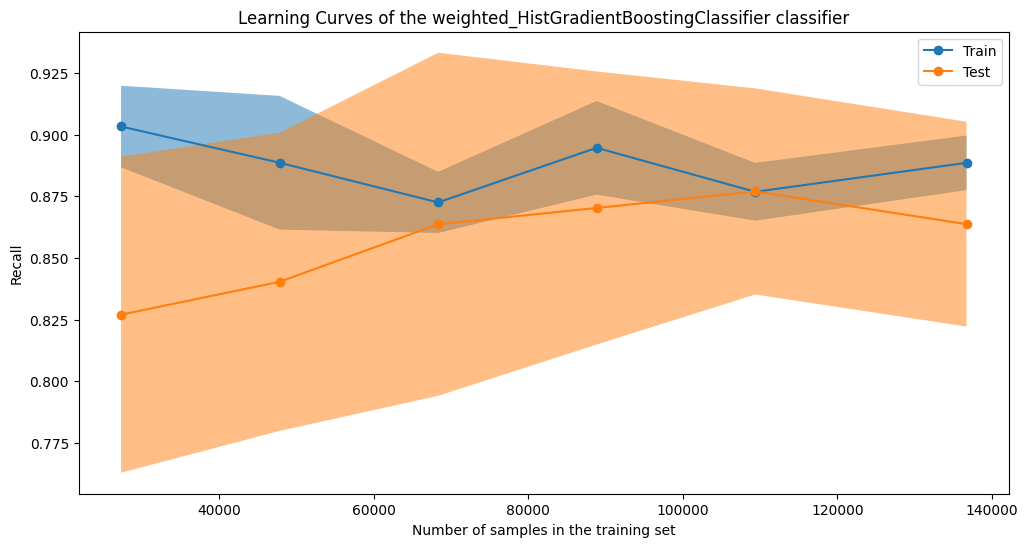

In [40]:
xgb_3 = HistGradientBoostingClassifier(max_depth=2, learning_rate= 0.01, early_stopping=True, class_weight='balanced')


displayLearningCurves(
    xgb_3, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'recall',
    'Recall',
    'weighted',
)


In [41]:
xgb_3.fit(x_train,y_train)
print(classification_report(y_val, xgb_3.predict(x_val), target_names = ['Non-Fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-Fraudulent       1.00      0.98      0.99     56869
    Fraudulent       0.06      0.88      0.12        93

      accuracy                           0.98     56962
     macro avg       0.53      0.93      0.55     56962
  weighted avg       1.00      0.98      0.99     56962



#### Support Vector Machine

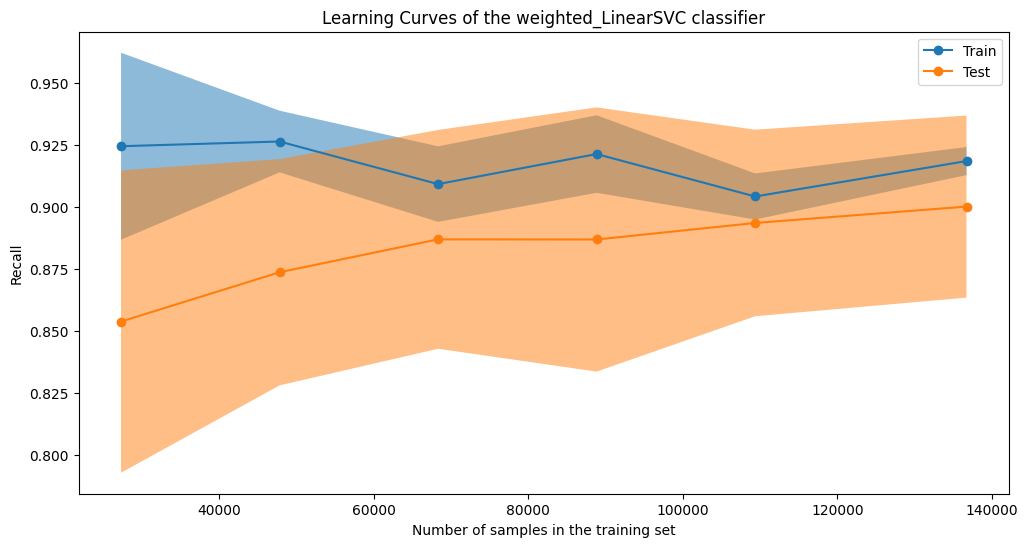

In [42]:
svc_3 = LinearSVC(class_weight='balanced')
displayLearningCurves(
    svc_3, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'recall',
    'Recall',
    'weighted'
)


In [43]:
svc_3.fit(x_train,y_train)
print(classification_report(y_val, svc_3.predict(x_val), target_names = ['Non-Fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-Fraudulent       1.00      0.98      0.99     56869
    Fraudulent       0.08      0.92      0.14        93

      accuracy                           0.98     56962
     macro avg       0.54      0.95      0.57     56962
  weighted avg       1.00      0.98      0.99     56962



### Wrap up:

In this section, we used the weighted loss function method to handle the class imbalance problem. 

Since the weight of each class is inversely proportional to its size, the models pay more attention to the minority class.

As a consequence, the recall of these models is generally higher, but the precision is much lower because they misclassify many normal transactions as fraudulent, leading to a higher number of false positives. Once again, the models did not overfit.

The best-performing model is **rf_3** with **Precision = 0.34** and **Recall = 0.88**

# Conclusion

In this project, we worked on a heavily imbalanced dataset.

We observed that accuracy is not the most appropriate performance metric when dealing with imbalanced data. Class-dependent metrics, such as precision and recall, provide more valuable insights in this context.

We explored four ML algorithms—LogisticRegression, RandomForestClassifier, HistGradientBoostingClassifier, and LinearSVC—each trained under three different scenarios to address the class imbalance problem: imbalanced, balanced, and weighted. Among these, the resampling technique yielded the most satisfying results.

We also examined the risk of overfitting. Fortunately, our models did not suffer from it.

**How to choose The Model?**

Choosing a model is hard, it's not just about maximizing performance metrics such as precision and recall. It requires domain expertise, sometimes model explainability(e.g., in the banking industry) is essential - not always the best performing model is the one in production. Building ML systems is a team effort, if you, as a ML engineer, happen to have expertise in the domain you're working in, it's great. But if it's not **communication is key**.

In our case, one may argue, since we're building a credit card fraud detection model, that the most important metric is **recall** which is understandable as we want our model to have the least amount of false negatives. Based on this criterion, we could choose the **svc_3 model** which has the best *recall of 92%*. This model perfectly fits the requirements, but what we didn't take into account is that this model could cause the loss of many clients: it has a *Precision of only 8%* meaning the system will flag too many false positives. Imagine how annoying it would be for customers if almost every transaction required verification. A fair question would be: what is the purpose of this ML system for a business without clients? 

If we take into account both **precision** and **recall** our best model is **xgb_2** with precision = 0.91 and recall = 0.92